In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
from scipy.optimize import curve_fit
from scipy import stats
from IPython.display import display, Math, Markdown

### Загрузка и первичная обработка фотографии спеклов

Введите имя файла фотографии спеклов:

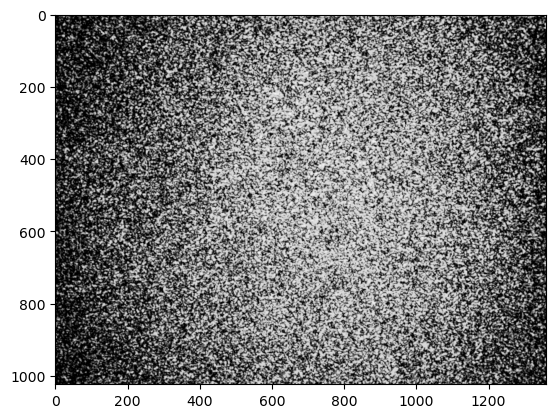

In [2]:
FILENAME = "30_20.bmp" # имя файла
img0 = np.mean(imread(FILENAME), axis=2) # усредняем 3 канала чтобы получить grayscale изображение
plt.imshow(img0, cmap='gray');

Поиск "центра масс" изображения:

$$\vec{r}_c = \frac{\sum\limits_i\vec{r}_i I_i}{\sum\limits_i I_i}$$

In [3]:
NX0 = img0.shape[1]
NY0 = img0.shape[0]

# создаём координатную сетку 
X, Y = np.meshgrid(np.arange(NX0),
                   np.arange(NY0))

M = np.sum(img0) # нормировка

# вычилсяем положение "центра масс"
xc0 = int(np.sum(np.multiply(X, img0)) / M)
yc0 = int(np.sum(np.multiply(Y, img0)) / M)

print("Xc = ", xc0, ", Yc = ", yc0)
MAXR = min(xc0, yc0, img0.shape[1] - xc0, img0.shape[0] - yc0) # максимальный радиус
print("max R = ", MAXR)

Xc =  726 , Yc =  509
max R =  509


Вырезаем прямоугольный участок заданного размера:

Средний уровень:  124.61620690054461 , разброс: 69.07546889954266


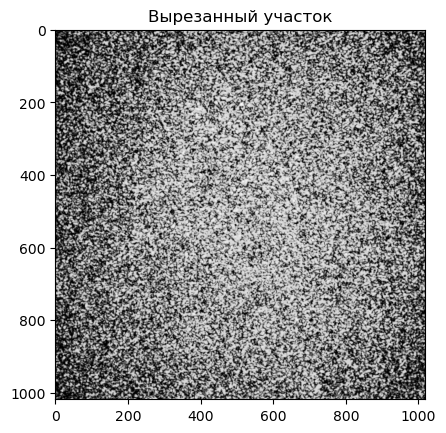

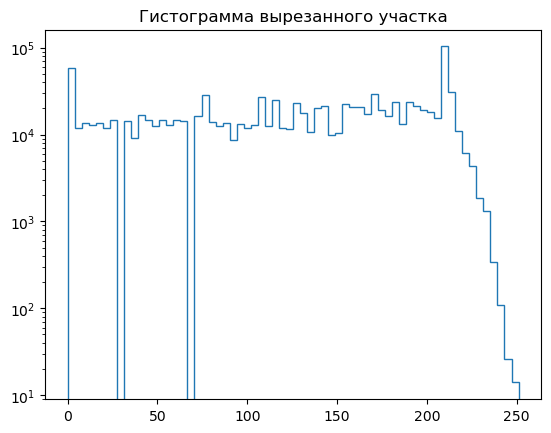

In [4]:
# Фукнция обрезки изображения
# rad -- размер области обрезки +- rad
# shitx, shity -- смещение от центра
def cut(img, rad, shiftx, shifty):
    iy, ix = img.shape
    return img[iy // 2 + shifty - rad : iy // 2 + shifty + rad, 
               ix // 2 + shiftx - rad : ix // 2 + shiftx + rad]

img = cut(img0, MAXR, xc0 - NX0//2, yc0 - NY0//2) # измените параметры обрезки при необходимости
MEAN = np.mean(img) # средее
MEAN2 = MEAN**2
VAR = np.var(img) # дисперсия
print("Средний уровень: ", MEAN, ", разброс:", np.sqrt(VAR))
plt.imshow(img, cmap='gray')
plt.title("Вырезанный участок")
plt.show()
plt.hist(img.flatten(), bins=64, histtype='step', log=True)
plt.title("Гистограмма вырезанного участка")
plt.show()

## Измерение корреляций

### Вычисление фукнции корреляции

Функции вычисление коэффициента автокорреляции для одномерного массива
$$\mathrm{cor}_j = \frac{\frac{1}{N}\sum\limits_{i=0}^N X_{i+j} X_i - \bar{X}^2}{\sigma_X^2}$$

*Замечание.* Вычисление полноценной двумерной корреляции -- вычислительно трудоёмкая задача. Поэтому вместо двумерной корреляциионной функции вычисляются одномерные корреляции (вдоль вертикальных и горизонтальных линий изображения) и производится их усреднение.

In [5]:
# коэффициент корреляции двух массивов
def corr(X1, X2, M2, D):
    return (np.dot(X1, X2) / len(X1) - M2) / D

# вычисление корреляции в одномерном случае
def corr_1D(X, R):
    M2 = np.mean(X)**2
    D = np.var(X)
    NR = len(R)
    cor = np.empty((NR,))
    for i in range(NR):
        rX = np.roll(X, R[i]) # циклически сдвигаем массив на заданный радиус
        cor[i] = corr(X, rX, M2, D)
    return cor

***Внимание!*** Подберите максимальное значение радиуса для функции корреляции так, чтобы число точек на участке с малыми корреляциями (при $C<0.1$) не превышало число точек на значимом участке ($C>0.1$).

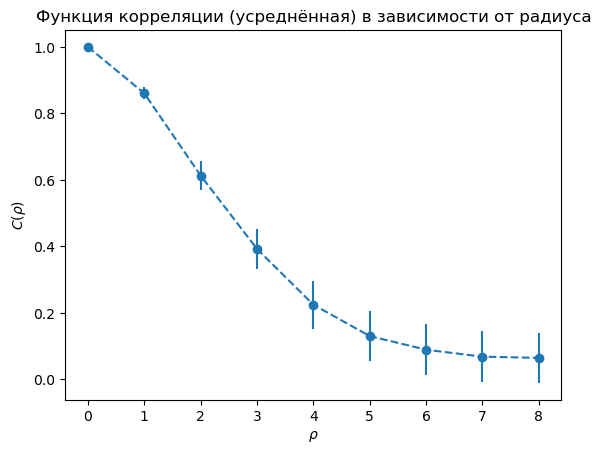

In [6]:
# максимальное значение радиуса корреляции (ПОДБЕРИТЕ САМОСТОЯТЕЛЬНО!)
MAX_RHO = 8

rho1 = np.arange(0, MAX_RHO + 1)
NX, NY = img.shape
C = np.empty((NX + NY, len(rho1)))
# вычисление одномерных корреляций по горизонтальным и вертикальным линиям
for i in range(NX):
    C[i,:] = corr_1D(img[i], rho1)
for i in range(NX, NX + NY):
    C[i,:] = corr_1D(img.T[i - NX], rho1)

# усреднение результатов
mC = np.mean(C, axis=0)
sC = np.std(C, axis=0, ddof=1) # погрешности
plt.errorbar(rho1, mC, yerr=sC, fmt='o--')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$C(\rho)$")
plt.title("Функция корреляции (усреднённая) в зависимости от радиуса");

### Вычисление радиуса корреляции

Аппроксимация корреляционной функции нормальным распределением:
$$f(\rho) = e^{-\rho ^2 / 2 \rho_C^2} $$

In [7]:
f = lambda x, sigma: np.exp(- 0.5 * (x / sigma)**2)

Вычисление радиуса корреляции с помощью численной нелинейной регрессии (метод наименьших квадратов для нелинейной функции):

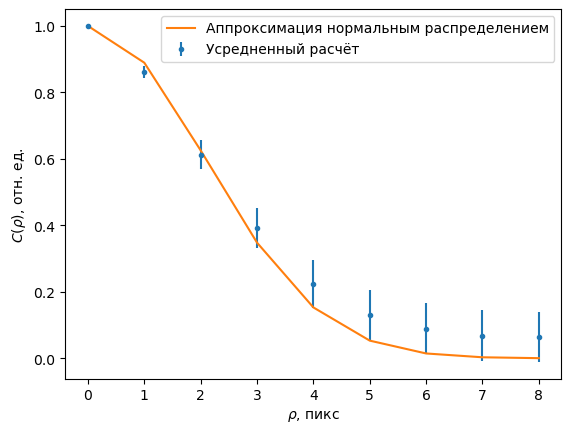

Радиус корреляции:

<IPython.core.display.Math object>

In [8]:
popt, pcov = curve_fit(f, rho1[1:], mC[1:], sigma=sC[1:]) # точку r = 0 исключаем как фиксированную
k = popt[0] #  наилучшее значение параметра
sk = np.sqrt(pcov[0,0]) #  среднеквадратичная погрешность

plt.errorbar(rho1, mC, yerr=sC, fmt='.', label='Усредненный расчёт')
plt.plot(rho1, f(rho1, k), '-', label='Аппроксимация нормальным распределением')
plt.xlabel("$\\rho$, пикс")
plt.ylabel("$С(\\rho)$, отн. ед.")
plt.legend()
plt.show()
display(Markdown('Радиус корреляции:'))
display(Math(r'\rho_C = %.2f \pm %.2f\;\text{[пикс]}' % (k, sk)))

### Анализ суммы хи-квадрат

In [9]:
# общее определение
def chi2(f, p, X, Y, sigma):
    return np.sum(((Y - f(X, p)) / sigma)**2)

Вычисляем сумму хи-квадрат, нормированную на число степеней свободы, и по её значению оцениваем качество аппроксимации.

In [10]:
_chi2 = lambda p: chi2(f, p, rho1, mC, sC)
minCHI2 = _chi2(k)
doF = len(rho1) - 1
CHI2_doF = minCHI2 / doF
display(Markdown(r'Сумма хи-квадрат, нормированная на число степеней свободы:'))
display(Math(r'\chi^2 / d_f = %.2f' % (CHI2_doF)))
display(Markdown(r'Вероятность того, что отклонения от модельной функции $f(\rho)$ случайны: $$P_{\rm err} = %.1f%s$$' % 
                 (stats.chi2.sf(minCHI2, doF) * 100, "\%")))

Сумма хи-квадрат, нормированная на число степеней свободы:

<IPython.core.display.Math object>

Вероятность того, что отклонения от модельной функции $f(\rho)$ случайны: $$P_{\rm err} = 46.7\%$$

Если $P_{\mathrm{err}} < 5\%$, аппроксимацию следует считать неудовлетворительной.

### Анализ погрешностей

Вычисление погрешности аппроксимации по значению суммы хи-квадрат. Уменьшение суммы хи-квадрат на единицу соответствует 68% доверительному интервалу.

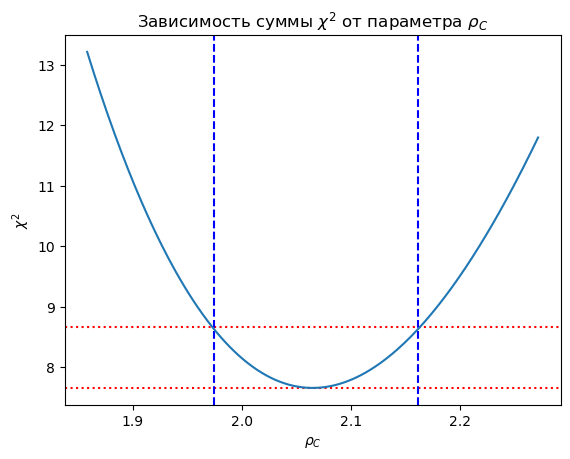

Радиус корреляции (с погрешностью по уровню значимости $P=0{,}68$):

<IPython.core.display.Math object>

In [11]:
LEVEL = 1
_sk = 0.1 * k # ширина анализируемого интервала
NK = 200 # число точек
_K = np.linspace(k - _sk, k + _sk, NK)
CHI2 = np.array([_chi2(_k) for _k in _K])

# левая граница
for i in range(len(_K)):
    if CHI2[i] <= minCHI2 + LEVEL:
        lS = k - _K[i]
        break
# правая граница
for i in range(len(_K) - 1, 0, -1):
    if CHI2[i] <= minCHI2 + LEVEL:
        rS = _K[i] - k
        break

plt.axhline(y = minCHI2, color='red',linestyle=':')
plt.axhline(y = minCHI2 + LEVEL, color='red', linestyle=':')
plt.axvline(x = k - lS, color='blue',linestyle='--')
plt.axvline(x = k + rS, color='blue',linestyle='--')
plt.plot(_K, CHI2)
plt.ylabel(r"$\chi^2$")
plt.xlabel(r"$\rho_C$")
plt.title(r"Зависимость суммы $\chi^2$ от параметра $\rho_C$")
plt.show()

display(Markdown(r'Радиус корреляции (с погрешностью по уровню значимости $P=0{,}68$):'))
display(Math(r'\rho_C = %.2f\,^{+\,%.2f}_{-%.2f}\;\text{[пикс]}' % (k, lS, rS)))

## Определение индикатрисы рассеяния

Вычислим гистограмму распределения интенсивности в зависимости от квадрата расстояния до "центра масс" картины. В гистограмме участвуют точки, отстоящие от центра не далее, чем  на $R_{max}$.

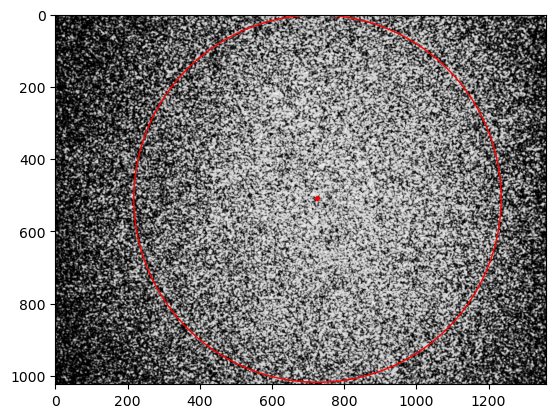

In [12]:
plt.imshow(img0, cmap='gray')
plt.gca().add_patch(plt.Circle((xc0, yc0), MAXR, color='red',fill=False))
plt.gca().add_patch(plt.Circle((xc0, yc0), 5, color='red',fill=True))
plt.show()

In [13]:
# Вычисляем квадраты расстояний до центра для всех точек изображения
R2 = (X.flatten() - xc0)**2 + (Y.flatten() - yc0)**2

# составляем пары (радиус, интенсивность), отбирая точки, для которых квадрат разности меньше максимального
MAXR2 = MAXR**2
R2Z = np.array([[r2, I] for r2, I in zip(R2, img0.flat) if r2 < MAXR2])

# вычисляем данные для гистограммы
NBINS = 100
bins = np.linspace(0, MAXR2, NBINS) # "корзины"
# считаем суммы значений интенсивностей, попавших в кажду "корзину"
bin_sums, bin_edges, _ = stats.binned_statistic(R2Z[:,0], R2Z[:,1], 
                                                bins=bins,
                                                statistic='sum')

# нормируем суммы (для удобства)
bin_sums = bin_sums / np.mean(bin_sums)

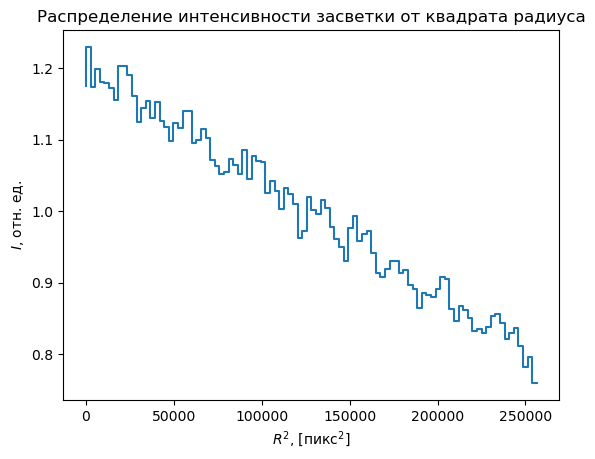

In [14]:
# строим график распределения
plt.step(bin_edges[:-1], bin_sums)
plt.xlabel("$R^2$, [пикс$^2$]")
plt.ylabel("$I$, отн. ед.")
plt.title("Распределение интенсивности засветки от квадрата радиуса")
plt.show()

Предполагаем, что интенсивность имеет нормальное распределение: $I \sim e^{-r^2 / 2 \rho_i^2}$. Тогда логарифм интенсивности должен быть линейной фукцией квадрата радиуса: $\ln I = -\frac12 k r^2 + b$, где $k = 1/\rho_i^2$.

Производим линейную аппроксимацию методом наименьших квадратов (поскольку погрешности точек не известны).

[3.22412798e-06 1.99300193e-01] [[3.07187536e-15 1.96956377e-10]
 [1.96956377e-10 1.69233133e-05]]
k = 3.224e-06 +- 5.542e-08


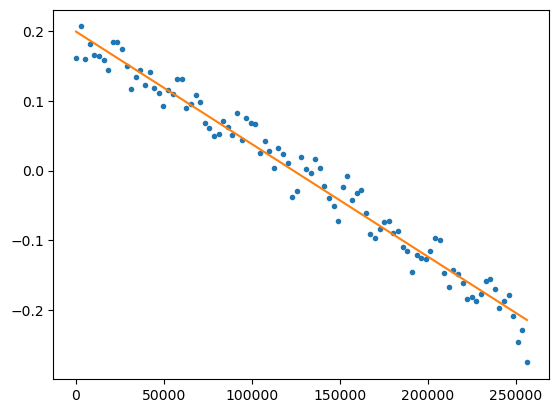

Радиус пучка:

<IPython.core.display.Math object>

In [15]:
g = lambda x, k, b: -0.5 * k * x + b
LI = np.log(bin_sums)
popt, pcov = curve_fit(g, bin_edges[:-1], LI)
print(popt, pcov)
print("k = %.3e +- %.3e" % (popt[0], np.sqrt(pcov[0,0])))

ri = np.sqrt(1/popt[0]) # rho_i = 1 / sqrt(k)
dri = (np.sqrt(pcov[0,0]) / popt[0]) * ri # drho_i = rho_i * dk / k

plt.plot(bin_edges[:-1], LI, '.')
plt.plot(bin_edges[:-1], g(bin_edges[:-1], *popt), '-')
plt.show()

display(Markdown(r'Радиус пучка:'))
display(Math(r'\rho_i = %.0f\pm %.0f\;\text{[пикс]}' % (ri, dri)))